# Imports

In [12]:
from catheter_utils import geometry
from dynamic_utils import *

%matplotlib inline

# Constants and Paths

In [13]:
# Main data paths for each catheter (manually input)
parent_path = '../data/processed/dynamic/'
catheter_paths = ['catheter231/', 'catheter299/', 'catheter306/']
main_paths = [parent_path + cath for cath in catheter_paths]

# Ground truth paths (to manually input)
GT_filename_home = [d + 'gt/home/GroundTruthCoords.csv' for d in main_paths] 
GT_filename_pos15 = [d + 'gt/p15/GroundTruthCoords.csv' for d in main_paths]
GT_filename_neg15 = [d + 'gt/n15/GroundTruthCoords.csv' for d in main_paths]
GT_filename_pos5 = [d + 'gt/p5/GroundTruthCoords.csv' for d in main_paths]
GT_filename_neg5 = [d + 'gt/n5/GroundTruthCoords.csv' for d in main_paths]

results_path = '../reports/figures/dynamic/'
# Where you would like to save the comparison plots (manually input)
comparison_plot_paths = [results_path + 'comparisonPlots/' + cath for cath in catheter_paths] #['../reports/figures/dynamic/comparisonPlots/catheter231/', '../reports/figures/dynamic/comparisonPlots/catheter299/', '../reports/figures/dynamic/comparisonPlots/catheter306/']

# Where you would like to save the box plots (manually input)
box_plot_path = results_path + 'boxPlots/'

sequences = ['HM', '3P']
cap = 'centroid_around_peak'
jpng = 'jpng'

# Recordings for each motion profile
recordings = [ [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'}, 
                 
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ] ]

# Get ground truth info
GT_home_coords_dfs = [get_gt_coords(GT_filename_home[0]), get_gt_coords(GT_filename_home[1]), get_gt_coords(GT_filename_home[2])]
GT_pos15_coords_dfs = [get_gt_coords(GT_filename_pos15[0]), get_gt_coords(GT_filename_pos15[1]), get_gt_coords(GT_filename_pos15[2])]
GT_neg15_coords_dfs = [get_gt_coords(GT_filename_neg15[0]), get_gt_coords(GT_filename_neg15[1]), get_gt_coords(GT_filename_neg15[2])]
GT_pos5_coords_dfs = [get_gt_coords(GT_filename_pos5[0]), get_gt_coords(GT_filename_pos5[1]), get_gt_coords(GT_filename_pos5[2])]
GT_neg5_coords_dfs = [get_gt_coords(GT_filename_neg5[0]), get_gt_coords(GT_filename_neg5[1]), get_gt_coords(GT_filename_neg5[2])]

Constant Numerical Values

In [14]:
num_caths = 3
num_profs = 4

# Coil numbers
distal_index = 6
proximal_index = 7

# Amplitudes and periods
amplitude_resp = 15 # mm
period_resp = 4024 # ms

amplitude_card = 5 # mm
period_card = 1006 # ms

# Device geometry index
geometry_index = 1 # 1 for catheter, 2 for dilator

# Start indices for each motion profile

start_idx = [ [ {'{}'.format(sequences[0]): 98,
                 '{}'.format(sequences[1]): 43}, 
                        
                {'{}'.format(sequences[0]): 63,
                 '{}'.format(sequences[1]): 48} ], 

              [ {'{}'.format(sequences[0]): 88,
                 '{}'.format(sequences[1]): 52}, 
                        
                {'{}'.format(sequences[0]): 81,
                 '{}'.format(sequences[1]): 45} ], 

              [ {'{}'.format(sequences[0]): 62,
                 '{}'.format(sequences[1]): 35}, 
                        
                {'{}'.format(sequences[0]): 60,
                 '{}'.format(sequences[1]): 31} ] ]

# Get ground truth distal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

# Get ground truth proximal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

# Calculate unit vectors using distal/proximal coords
unit_vectors_from_dist_resp = np.abs([calc_unit_vector(home_dist_coords[0], pos15_dist_coords[0], neg15_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos15_dist_coords[1], neg15_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos15_dist_coords[2], neg15_dist_coords[2])])
unit_vectors_from_prox_resp = np.abs([calc_unit_vector(home_prox_coords[0], pos15_prox_coords[0], neg15_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos15_prox_coords[1], neg15_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos15_prox_coords[2], neg15_prox_coords[2])])
unit_vectors_from_dist_card = np.abs([calc_unit_vector(home_dist_coords[0], pos5_dist_coords[0], neg5_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos5_dist_coords[1], neg5_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos5_dist_coords[2], neg5_dist_coords[2])])
unit_vectors_from_prox_card = np.abs([calc_unit_vector(home_prox_coords[0], pos5_prox_coords[0], neg5_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos5_prox_coords[1], neg5_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos5_prox_coords[2], neg5_prox_coords[2])])

unit_vectors_from_dist_resp[0][0] = -1 * unit_vectors_from_dist_resp[0][0] # Need to do this for some reason

Dataframes for Coil Tracking Data

In [15]:
# Convert coil cathcoords to dataframes

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, distal_index,   recordings[0][0][sequences[0]])
FH512_2_jpng_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, proximal_index, recordings[0][0][sequences[0]])
FH512_2_jpng_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, distal_index,   recordings[0][1][sequences[0]])
FH512_2_jpng_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, proximal_index, recordings[0][1][sequences[0]])

FH512_2_jpng_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, distal_index,   recordings[1][0][sequences[0]])
FH512_2_jpng_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, proximal_index, recordings[1][0][sequences[0]])
FH512_2_jpng_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, distal_index,   recordings[1][1][sequences[0]])
FH512_2_jpng_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, proximal_index, recordings[1][1][sequences[0]])

FH512_2_jpng_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, distal_index,   recordings[2][0][sequences[0]])
FH512_2_jpng_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, proximal_index, recordings[2][0][sequences[0]])
FH512_2_jpng_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, distal_index,   recordings[2][1][sequences[0]])
FH512_2_jpng_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, proximal_index, recordings[2][1][sequences[0]])

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, distal_index,   recordings[0][0][sequences[0]])
FH512_2_cap_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, proximal_index, recordings[0][0][sequences[0]])
FH512_2_cap_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, distal_index,   recordings[0][1][sequences[0]])
FH512_2_cap_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, proximal_index, recordings[0][1][sequences[0]])

FH512_2_cap_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, distal_index,   recordings[1][0][sequences[0]])
FH512_2_cap_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, proximal_index, recordings[1][0][sequences[0]])
FH512_2_cap_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, distal_index,   recordings[1][1][sequences[0]])
FH512_2_cap_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, proximal_index, recordings[1][1][sequences[0]])

FH512_2_cap_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, distal_index,   recordings[2][0][sequences[0]])
FH512_2_cap_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, proximal_index, recordings[2][0][sequences[0]])
FH512_2_cap_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, distal_index,   recordings[2][1][sequences[0]])
FH512_2_cap_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, proximal_index, recordings[2][1][sequences[0]])

# Sequence 2: Conventional - JPNG
SRI_2_jpng_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, distal_index,   recordings[0][0][sequences[1]])
SRI_2_jpng_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, proximal_index, recordings[0][0][sequences[1]])
SRI_2_jpng_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, distal_index,   recordings[0][1][sequences[1]])
SRI_2_jpng_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, proximal_index, recordings[0][1][sequences[1]])

SRI_2_jpng_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, distal_index,   recordings[1][0][sequences[1]])
SRI_2_jpng_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, proximal_index, recordings[1][0][sequences[1]])
SRI_2_jpng_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, distal_index,   recordings[1][1][sequences[1]])
SRI_2_jpng_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, proximal_index, recordings[1][1][sequences[1]])

SRI_2_jpng_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, distal_index,   recordings[2][0][sequences[1]])
SRI_2_jpng_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, proximal_index, recordings[2][0][sequences[1]])
SRI_2_jpng_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, distal_index,   recordings[2][1][sequences[1]])
SRI_2_jpng_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, proximal_index, recordings[2][1][sequences[1]])

# Sequence 2: Conventional - CAP
SRI_2_cap_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, distal_index,   recordings[0][0][sequences[1]])
SRI_2_cap_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, proximal_index, recordings[0][0][sequences[1]])
SRI_2_cap_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, distal_index,   recordings[0][1][sequences[1]])
SRI_2_cap_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, proximal_index, recordings[0][1][sequences[1]])

SRI_2_cap_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, distal_index,   recordings[1][0][sequences[1]])
SRI_2_cap_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, proximal_index, recordings[1][0][sequences[1]])
SRI_2_cap_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, distal_index,   recordings[1][1][sequences[1]])
SRI_2_cap_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, proximal_index, recordings[1][1][sequences[1]])

SRI_2_cap_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, distal_index,   recordings[2][0][sequences[1]])
SRI_2_cap_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, proximal_index, recordings[2][0][sequences[1]])
SRI_2_cap_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, distal_index,   recordings[2][1][sequences[1]])
SRI_2_cap_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, proximal_index, recordings[2][1][sequences[1]])

Dataframes for Tip Tracking Data

In [16]:
# Get tip coords from tracked data

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tip_231_resp = get_tip_coords(FH512_2_jpng_7_231_resp, FH512_2_jpng_6_231_resp, geometry_index)
FH512_2_jpng_tip_231_card = get_tip_coords(FH512_2_jpng_7_231_card, FH512_2_jpng_6_231_card, geometry_index)

FH512_2_jpng_tip_299_resp = get_tip_coords(FH512_2_jpng_7_299_resp, FH512_2_jpng_6_299_resp, geometry_index)
FH512_2_jpng_tip_299_card = get_tip_coords(FH512_2_jpng_7_299_card, FH512_2_jpng_6_299_card, geometry_index)

FH512_2_jpng_tip_306_resp = get_tip_coords(FH512_2_jpng_7_306_resp, FH512_2_jpng_6_306_resp, geometry_index)
FH512_2_jpng_tip_306_card = get_tip_coords(FH512_2_jpng_7_306_card, FH512_2_jpng_6_306_card, geometry_index)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tip_231_resp = get_tip_coords(FH512_2_cap_7_231_resp, FH512_2_cap_6_231_resp, geometry_index)
FH512_2_cap_tip_231_card = get_tip_coords(FH512_2_cap_7_231_card, FH512_2_cap_6_231_card, geometry_index)

FH512_2_cap_tip_299_resp = get_tip_coords(FH512_2_cap_7_299_resp, FH512_2_cap_6_299_resp, geometry_index)
FH512_2_cap_tip_299_card = get_tip_coords(FH512_2_cap_7_299_card, FH512_2_cap_6_299_card, geometry_index)

FH512_2_cap_tip_306_resp = get_tip_coords(FH512_2_cap_7_306_resp, FH512_2_cap_6_306_resp, geometry_index)
FH512_2_cap_tip_306_card = get_tip_coords(FH512_2_cap_7_306_card, FH512_2_cap_6_306_card, geometry_index)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tip_231_resp = get_tip_coords(SRI_2_jpng_7_231_resp, SRI_2_jpng_6_231_resp, geometry_index)
SRI_2_jpng_tip_231_card = get_tip_coords(SRI_2_jpng_7_231_card, SRI_2_jpng_6_231_card, geometry_index)

SRI_2_jpng_tip_299_resp = get_tip_coords(SRI_2_jpng_7_299_resp, SRI_2_jpng_6_299_resp, geometry_index)
SRI_2_jpng_tip_299_card = get_tip_coords(SRI_2_jpng_7_299_card, SRI_2_jpng_6_299_card, geometry_index)

SRI_2_jpng_tip_306_resp = get_tip_coords(SRI_2_jpng_7_306_resp, SRI_2_jpng_6_306_resp, geometry_index)
SRI_2_jpng_tip_306_card = get_tip_coords(SRI_2_jpng_7_306_card, SRI_2_jpng_6_306_card, geometry_index)

# Sequence 2: Conventional - CAP
SRI_2_cap_tip_231_resp = get_tip_coords(SRI_2_cap_7_231_resp, SRI_2_cap_6_231_resp, geometry_index)
SRI_2_cap_tip_231_card = get_tip_coords(SRI_2_cap_7_231_card, SRI_2_cap_6_231_card, geometry_index)

SRI_2_cap_tip_299_resp = get_tip_coords(SRI_2_cap_7_299_resp, SRI_2_cap_6_299_resp, geometry_index)
SRI_2_cap_tip_299_card = get_tip_coords(SRI_2_cap_7_299_card, SRI_2_cap_6_299_card, geometry_index)

SRI_2_cap_tip_306_resp = get_tip_coords(SRI_2_cap_7_306_resp, SRI_2_cap_6_306_resp, geometry_index)
SRI_2_cap_tip_306_card = get_tip_coords(SRI_2_cap_7_306_card, SRI_2_cap_6_306_card, geometry_index)


Dataframes for Ground Truth (Expected) Coil Data

In [17]:
# Get expected coil coords for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_6_expected_231_resp = get_expected_coords_resp(FH512_2_jpng_6_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_231_resp = get_expected_coords_resp(FH512_2_jpng_7_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_231_card = get_expected_coords_card(FH512_2_jpng_6_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
FH512_2_jpng_7_expected_231_card = get_expected_coords_card(FH512_2_jpng_7_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

FH512_2_jpng_6_expected_299_resp = get_expected_coords_resp(FH512_2_jpng_6_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_299_resp = get_expected_coords_resp(FH512_2_jpng_7_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_299_card = get_expected_coords_card(FH512_2_jpng_6_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
FH512_2_jpng_7_expected_299_card = get_expected_coords_card(FH512_2_jpng_7_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

FH512_2_jpng_6_expected_306_resp = get_expected_coords_resp(FH512_2_jpng_6_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_306_resp = get_expected_coords_resp(FH512_2_jpng_7_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_306_card = get_expected_coords_card(FH512_2_jpng_6_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
FH512_2_jpng_7_expected_306_card = get_expected_coords_card(FH512_2_jpng_7_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_6_expected_231_resp = get_expected_coords_resp(FH512_2_cap_6_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
FH512_2_cap_7_expected_231_resp = get_expected_coords_resp(FH512_2_cap_7_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
FH512_2_cap_6_expected_231_card = get_expected_coords_card(FH512_2_cap_6_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
FH512_2_cap_7_expected_231_card = get_expected_coords_card(FH512_2_cap_7_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

FH512_2_cap_6_expected_299_resp = get_expected_coords_resp(FH512_2_cap_6_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
FH512_2_cap_7_expected_299_resp = get_expected_coords_resp(FH512_2_cap_7_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
FH512_2_cap_6_expected_299_card = get_expected_coords_card(FH512_2_cap_6_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
FH512_2_cap_7_expected_299_card = get_expected_coords_card(FH512_2_cap_7_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

FH512_2_cap_6_expected_306_resp = get_expected_coords_resp(FH512_2_cap_6_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
FH512_2_cap_7_expected_306_resp = get_expected_coords_resp(FH512_2_cap_7_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
FH512_2_cap_6_expected_306_card = get_expected_coords_card(FH512_2_cap_6_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
FH512_2_cap_7_expected_306_card = get_expected_coords_card(FH512_2_cap_7_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_6_expected_231_resp = get_expected_coords_resp(SRI_2_jpng_6_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_231_resp = get_expected_coords_resp(SRI_2_jpng_7_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_231_card = get_expected_coords_card(SRI_2_jpng_6_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
SRI_2_jpng_7_expected_231_card = get_expected_coords_card(SRI_2_jpng_7_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

SRI_2_jpng_6_expected_299_resp = get_expected_coords_resp(SRI_2_jpng_6_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_299_resp = get_expected_coords_resp(SRI_2_jpng_7_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_299_card = get_expected_coords_card(SRI_2_jpng_6_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
SRI_2_jpng_7_expected_299_card = get_expected_coords_card(SRI_2_jpng_7_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

SRI_2_jpng_6_expected_306_resp = get_expected_coords_resp(SRI_2_jpng_6_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_306_resp = get_expected_coords_resp(SRI_2_jpng_7_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_306_card = get_expected_coords_card(SRI_2_jpng_6_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
SRI_2_jpng_7_expected_306_card = get_expected_coords_card(SRI_2_jpng_7_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 2: Conventional - CAP
SRI_2_cap_6_expected_231_resp = get_expected_coords_resp(SRI_2_cap_6_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
SRI_2_cap_7_expected_231_resp = get_expected_coords_resp(SRI_2_cap_7_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
SRI_2_cap_6_expected_231_card = get_expected_coords_card(SRI_2_cap_6_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
SRI_2_cap_7_expected_231_card = get_expected_coords_card(SRI_2_cap_7_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

SRI_2_cap_6_expected_299_resp = get_expected_coords_resp(SRI_2_cap_6_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
SRI_2_cap_7_expected_299_resp = get_expected_coords_resp(SRI_2_cap_7_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
SRI_2_cap_6_expected_299_card = get_expected_coords_card(SRI_2_cap_6_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
SRI_2_cap_7_expected_299_card = get_expected_coords_card(SRI_2_cap_7_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

SRI_2_cap_6_expected_306_resp = get_expected_coords_resp(SRI_2_cap_6_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
SRI_2_cap_7_expected_306_resp = get_expected_coords_resp(SRI_2_cap_7_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
SRI_2_cap_6_expected_306_card = get_expected_coords_card(SRI_2_cap_6_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
SRI_2_cap_7_expected_306_card = get_expected_coords_card(SRI_2_cap_7_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)


Dataframes for GT (Expected) Tip Data

In [18]:
# Get GT expected tip coords for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tip_expected_231_resp = get_tip_coords(FH512_2_jpng_7_expected_231_resp, FH512_2_jpng_6_expected_231_resp, geometry_index)
FH512_2_jpng_tip_expected_231_card = get_tip_coords(FH512_2_jpng_7_expected_231_card, FH512_2_jpng_6_expected_231_card, geometry_index)

FH512_2_jpng_tip_expected_299_resp = get_tip_coords(FH512_2_jpng_7_expected_299_resp, FH512_2_jpng_6_expected_299_resp, geometry_index)
FH512_2_jpng_tip_expected_299_card = get_tip_coords(FH512_2_jpng_7_expected_299_card, FH512_2_jpng_6_expected_299_card, geometry_index)

FH512_2_jpng_tip_expected_306_resp = get_tip_coords(FH512_2_jpng_7_expected_306_resp, FH512_2_jpng_6_expected_306_resp, geometry_index)
FH512_2_jpng_tip_expected_306_card = get_tip_coords(FH512_2_jpng_7_expected_306_card, FH512_2_jpng_6_expected_306_card, geometry_index)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tip_expected_231_resp = get_tip_coords(FH512_2_cap_7_expected_231_resp, FH512_2_cap_6_expected_231_resp, geometry_index)
FH512_2_cap_tip_expected_231_card = get_tip_coords(FH512_2_cap_7_expected_231_card, FH512_2_cap_6_expected_231_card, geometry_index)

FH512_2_cap_tip_expected_299_resp = get_tip_coords(FH512_2_cap_7_expected_299_resp, FH512_2_cap_6_expected_299_resp, geometry_index)
FH512_2_cap_tip_expected_299_card = get_tip_coords(FH512_2_cap_7_expected_299_card, FH512_2_cap_6_expected_299_card, geometry_index)

FH512_2_cap_tip_expected_306_resp = get_tip_coords(FH512_2_cap_7_expected_306_resp, FH512_2_cap_6_expected_306_resp, geometry_index)
FH512_2_cap_tip_expected_306_card = get_tip_coords(FH512_2_cap_7_expected_306_card, FH512_2_cap_6_expected_306_card, geometry_index)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tip_expected_231_resp = get_tip_coords(SRI_2_jpng_7_expected_231_resp, SRI_2_jpng_6_expected_231_resp, geometry_index)
SRI_2_jpng_tip_expected_231_card = get_tip_coords(SRI_2_jpng_7_expected_231_card, SRI_2_jpng_6_expected_231_card, geometry_index)

SRI_2_jpng_tip_expected_299_resp = get_tip_coords(SRI_2_jpng_7_expected_299_resp, SRI_2_jpng_6_expected_299_resp, geometry_index)
SRI_2_jpng_tip_expected_299_card = get_tip_coords(SRI_2_jpng_7_expected_299_card, SRI_2_jpng_6_expected_299_card, geometry_index)

SRI_2_jpng_tip_expected_306_resp = get_tip_coords(SRI_2_jpng_7_expected_306_resp, SRI_2_jpng_6_expected_306_resp, geometry_index)
SRI_2_jpng_tip_expected_306_card = get_tip_coords(SRI_2_jpng_7_expected_306_card, SRI_2_jpng_6_expected_306_card, geometry_index)

# Sequence 2: Conventional - CAP
SRI_2_cap_tip_expected_231_resp = get_tip_coords(SRI_2_cap_7_expected_231_resp, SRI_2_cap_6_expected_231_resp, geometry_index)
SRI_2_cap_tip_expected_231_card = get_tip_coords(SRI_2_cap_7_expected_231_card, SRI_2_cap_6_expected_231_card, geometry_index)

SRI_2_cap_tip_expected_299_resp = get_tip_coords(SRI_2_cap_7_expected_299_resp, SRI_2_cap_6_expected_299_resp, geometry_index)
SRI_2_cap_tip_expected_299_card = get_tip_coords(SRI_2_cap_7_expected_299_card, SRI_2_cap_6_expected_299_card, geometry_index)

SRI_2_cap_tip_expected_306_resp = get_tip_coords(SRI_2_cap_7_expected_306_resp, SRI_2_cap_6_expected_306_resp, geometry_index)
SRI_2_cap_tip_expected_306_card = get_tip_coords(SRI_2_cap_7_expected_306_card, SRI_2_cap_6_expected_306_card, geometry_index)


Calculate Error Between Tracked (Measured) and Ground Truth (Expected) Data

In [19]:
# Calculate error for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tracked_dataframes_231_resp  = [FH512_2_jpng_7_231_resp, FH512_2_jpng_6_231_resp, FH512_2_jpng_tip_231_resp]
FH512_2_jpng_expected_dataframes_231_resp = [FH512_2_jpng_7_expected_231_resp, FH512_2_jpng_6_expected_231_resp, FH512_2_jpng_tip_expected_231_resp]
FH512_2_jpng_plot_df_231_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_231_resp, FH512_2_jpng_expected_dataframes_231_resp, start_idx[0][0][sequences[0]])
FH512_2_jpng_tracked_dataframes_231_card  = [FH512_2_jpng_7_231_card, FH512_2_jpng_6_231_card, FH512_2_jpng_tip_231_card]
FH512_2_jpng_expected_dataframes_231_card = [FH512_2_jpng_7_expected_231_card, FH512_2_jpng_6_expected_231_card, FH512_2_jpng_tip_expected_231_card]
FH512_2_jpng_plot_df_231_card             = calculate_error(FH512_2_jpng_tracked_dataframes_231_card, FH512_2_jpng_expected_dataframes_231_card, start_idx[0][1][sequences[0]])

FH512_2_jpng_tracked_dataframes_299_resp  = [FH512_2_jpng_7_299_resp, FH512_2_jpng_6_299_resp, FH512_2_jpng_tip_299_resp]
FH512_2_jpng_expected_dataframes_299_resp = [FH512_2_jpng_7_expected_299_resp, FH512_2_jpng_6_expected_299_resp, FH512_2_jpng_tip_expected_299_resp]
FH512_2_jpng_plot_df_299_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_299_resp, FH512_2_jpng_expected_dataframes_299_resp, start_idx[1][0][sequences[0]])
FH512_2_jpng_tracked_dataframes_299_card  = [FH512_2_jpng_7_299_card, FH512_2_jpng_6_299_card, FH512_2_jpng_tip_299_card]
FH512_2_jpng_expected_dataframes_299_card = [FH512_2_jpng_7_expected_299_card, FH512_2_jpng_6_expected_299_card, FH512_2_jpng_tip_expected_299_card]
FH512_2_jpng_plot_df_299_card             = calculate_error(FH512_2_jpng_tracked_dataframes_299_card, FH512_2_jpng_expected_dataframes_299_card, start_idx[1][1][sequences[0]])

FH512_2_jpng_tracked_dataframes_306_resp  = [FH512_2_jpng_7_306_resp, FH512_2_jpng_6_306_resp, FH512_2_jpng_tip_306_resp]
FH512_2_jpng_expected_dataframes_306_resp = [FH512_2_jpng_7_expected_306_resp, FH512_2_jpng_6_expected_306_resp, FH512_2_jpng_tip_expected_306_resp]
FH512_2_jpng_plot_df_306_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_306_resp, FH512_2_jpng_expected_dataframes_306_resp, start_idx[2][0][sequences[0]])
FH512_2_jpng_tracked_dataframes_306_card  = [FH512_2_jpng_7_306_card, FH512_2_jpng_6_306_card, FH512_2_jpng_tip_306_card]
FH512_2_jpng_expected_dataframes_306_card = [FH512_2_jpng_7_expected_306_card, FH512_2_jpng_6_expected_306_card, FH512_2_jpng_tip_expected_306_card]
FH512_2_jpng_plot_df_306_card             = calculate_error(FH512_2_jpng_tracked_dataframes_306_card, FH512_2_jpng_expected_dataframes_306_card, start_idx[2][1][sequences[0]])

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tracked_dataframes_231_resp  = [FH512_2_cap_7_231_resp, FH512_2_cap_6_231_resp, FH512_2_cap_tip_231_resp]
FH512_2_cap_expected_dataframes_231_resp = [FH512_2_cap_7_expected_231_resp, FH512_2_cap_6_expected_231_resp, FH512_2_cap_tip_expected_231_resp]
FH512_2_cap_plot_df_231_resp             = calculate_error(FH512_2_cap_tracked_dataframes_231_resp, FH512_2_cap_expected_dataframes_231_resp, start_idx[0][0][sequences[0]])
FH512_2_cap_tracked_dataframes_231_card  = [FH512_2_cap_7_231_card, FH512_2_cap_6_231_card, FH512_2_cap_tip_231_card]
FH512_2_cap_expected_dataframes_231_card = [FH512_2_cap_7_expected_231_card, FH512_2_cap_6_expected_231_card, FH512_2_cap_tip_expected_231_card]
FH512_2_cap_plot_df_231_card             = calculate_error(FH512_2_cap_tracked_dataframes_231_card, FH512_2_cap_expected_dataframes_231_card, start_idx[0][1][sequences[0]])

FH512_2_cap_tracked_dataframes_299_resp  = [FH512_2_cap_7_299_resp, FH512_2_cap_6_299_resp, FH512_2_cap_tip_299_resp]
FH512_2_cap_expected_dataframes_299_resp = [FH512_2_cap_7_expected_299_resp, FH512_2_cap_6_expected_299_resp, FH512_2_cap_tip_expected_299_resp]
FH512_2_cap_plot_df_299_resp             = calculate_error(FH512_2_cap_tracked_dataframes_299_resp, FH512_2_cap_expected_dataframes_299_resp, start_idx[1][0][sequences[0]])
FH512_2_cap_tracked_dataframes_299_card  = [FH512_2_cap_7_299_card, FH512_2_cap_6_299_card, FH512_2_cap_tip_299_card]
FH512_2_cap_expected_dataframes_299_card = [FH512_2_cap_7_expected_299_card, FH512_2_cap_6_expected_299_card, FH512_2_cap_tip_expected_299_card]
FH512_2_cap_plot_df_299_card             = calculate_error(FH512_2_cap_tracked_dataframes_299_card, FH512_2_cap_expected_dataframes_299_card, start_idx[1][1][sequences[0]])

FH512_2_cap_tracked_dataframes_306_resp  = [FH512_2_cap_7_306_resp, FH512_2_cap_6_306_resp, FH512_2_cap_tip_306_resp]
FH512_2_cap_expected_dataframes_306_resp = [FH512_2_cap_7_expected_306_resp, FH512_2_cap_6_expected_306_resp, FH512_2_cap_tip_expected_306_resp]
FH512_2_cap_plot_df_306_resp             = calculate_error(FH512_2_cap_tracked_dataframes_306_resp, FH512_2_cap_expected_dataframes_306_resp, start_idx[2][0][sequences[0]])
FH512_2_cap_tracked_dataframes_306_card  = [FH512_2_cap_7_306_card, FH512_2_cap_6_306_card, FH512_2_cap_tip_306_card]
FH512_2_cap_expected_dataframes_306_card = [FH512_2_cap_7_expected_306_card, FH512_2_cap_6_expected_306_card, FH512_2_cap_tip_expected_306_card]
FH512_2_cap_plot_df_306_card             = calculate_error(FH512_2_cap_tracked_dataframes_306_card, FH512_2_cap_expected_dataframes_306_card, start_idx[2][1][sequences[0]])

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tracked_dataframes_231_resp  = [SRI_2_jpng_7_231_resp, SRI_2_jpng_6_231_resp, SRI_2_jpng_tip_231_resp]
SRI_2_jpng_expected_dataframes_231_resp = [SRI_2_jpng_7_expected_231_resp, SRI_2_jpng_6_expected_231_resp, SRI_2_jpng_tip_expected_231_resp]
SRI_2_jpng_plot_df_231_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_231_resp, SRI_2_jpng_expected_dataframes_231_resp, start_idx[0][0][sequences[1]])
SRI_2_jpng_tracked_dataframes_231_card  = [SRI_2_jpng_7_231_card, SRI_2_jpng_6_231_card, SRI_2_jpng_tip_231_card]
SRI_2_jpng_expected_dataframes_231_card = [SRI_2_jpng_7_expected_231_card, SRI_2_jpng_6_expected_231_card, SRI_2_jpng_tip_expected_231_card]
SRI_2_jpng_plot_df_231_card             = calculate_error(SRI_2_jpng_tracked_dataframes_231_card, SRI_2_jpng_expected_dataframes_231_card, start_idx[0][1][sequences[1]])

SRI_2_jpng_tracked_dataframes_299_resp  = [SRI_2_jpng_7_299_resp, SRI_2_jpng_6_299_resp, SRI_2_jpng_tip_299_resp]
SRI_2_jpng_expected_dataframes_299_resp = [SRI_2_jpng_7_expected_299_resp, SRI_2_jpng_6_expected_299_resp, SRI_2_jpng_tip_expected_299_resp]
SRI_2_jpng_plot_df_299_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_299_resp, SRI_2_jpng_expected_dataframes_299_resp, start_idx[1][0][sequences[1]])
SRI_2_jpng_tracked_dataframes_299_card  = [SRI_2_jpng_7_299_card, SRI_2_jpng_6_299_card, SRI_2_jpng_tip_299_card]
SRI_2_jpng_expected_dataframes_299_card = [SRI_2_jpng_7_expected_299_card, SRI_2_jpng_6_expected_299_card, SRI_2_jpng_tip_expected_299_card]
SRI_2_jpng_plot_df_299_card             = calculate_error(SRI_2_jpng_tracked_dataframes_299_card, SRI_2_jpng_expected_dataframes_299_card, start_idx[1][1][sequences[1]])

SRI_2_jpng_tracked_dataframes_306_resp  = [SRI_2_jpng_7_306_resp, SRI_2_jpng_6_306_resp, SRI_2_jpng_tip_306_resp]
SRI_2_jpng_expected_dataframes_306_resp = [SRI_2_jpng_7_expected_306_resp, SRI_2_jpng_6_expected_306_resp, SRI_2_jpng_tip_expected_306_resp]
SRI_2_jpng_plot_df_306_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_306_resp, SRI_2_jpng_expected_dataframes_306_resp, start_idx[2][0][sequences[1]])
SRI_2_jpng_tracked_dataframes_306_card  = [SRI_2_jpng_7_306_card, SRI_2_jpng_6_306_card, SRI_2_jpng_tip_306_card]
SRI_2_jpng_expected_dataframes_306_card = [SRI_2_jpng_7_expected_306_card, SRI_2_jpng_6_expected_306_card, SRI_2_jpng_tip_expected_306_card]
SRI_2_jpng_plot_df_306_card             = calculate_error(SRI_2_jpng_tracked_dataframes_306_card, SRI_2_jpng_expected_dataframes_306_card, start_idx[2][1][sequences[1]])

# Sequence 2: Conventional - CAP
SRI_2_cap_tracked_dataframes_231_resp  = [SRI_2_cap_7_231_resp, SRI_2_cap_6_231_resp, SRI_2_cap_tip_231_resp]
SRI_2_cap_expected_dataframes_231_resp = [SRI_2_cap_7_expected_231_resp, SRI_2_cap_6_expected_231_resp, SRI_2_cap_tip_expected_231_resp]
SRI_2_cap_plot_df_231_resp             = calculate_error(SRI_2_cap_tracked_dataframes_231_resp, SRI_2_cap_expected_dataframes_231_resp, start_idx[0][0][sequences[1]])
SRI_2_cap_tracked_dataframes_231_card  = [SRI_2_cap_7_231_card, SRI_2_cap_6_231_card, SRI_2_cap_tip_231_card]
SRI_2_cap_expected_dataframes_231_card = [SRI_2_cap_7_expected_231_card, SRI_2_cap_6_expected_231_card, SRI_2_cap_tip_expected_231_card]
SRI_2_cap_plot_df_231_card             = calculate_error(SRI_2_cap_tracked_dataframes_231_card, SRI_2_cap_expected_dataframes_231_card, start_idx[0][1][sequences[1]])

SRI_2_cap_tracked_dataframes_299_resp  = [SRI_2_cap_7_299_resp, SRI_2_cap_6_299_resp, SRI_2_cap_tip_299_resp]
SRI_2_cap_expected_dataframes_299_resp = [SRI_2_cap_7_expected_299_resp, SRI_2_cap_6_expected_299_resp, SRI_2_cap_tip_expected_299_resp]
SRI_2_cap_plot_df_299_resp             = calculate_error(SRI_2_cap_tracked_dataframes_299_resp, SRI_2_cap_expected_dataframes_299_resp, start_idx[1][0][sequences[1]])
SRI_2_cap_tracked_dataframes_299_card  = [SRI_2_cap_7_299_card, SRI_2_cap_6_299_card, SRI_2_cap_tip_299_card]
SRI_2_cap_expected_dataframes_299_card = [SRI_2_cap_7_expected_299_card, SRI_2_cap_6_expected_299_card, SRI_2_cap_tip_expected_299_card]
SRI_2_cap_plot_df_299_card             = calculate_error(SRI_2_cap_tracked_dataframes_299_card, SRI_2_cap_expected_dataframes_299_card, start_idx[1][1][sequences[1]])

SRI_2_cap_tracked_dataframes_306_resp  = [SRI_2_cap_7_306_resp, SRI_2_cap_6_306_resp, SRI_2_cap_tip_306_resp]
SRI_2_cap_expected_dataframes_306_resp = [SRI_2_cap_7_expected_306_resp, SRI_2_cap_6_expected_306_resp, SRI_2_cap_tip_expected_306_resp]
SRI_2_cap_plot_df_306_resp             = calculate_error(SRI_2_cap_tracked_dataframes_306_resp, SRI_2_cap_expected_dataframes_306_resp, start_idx[2][0][sequences[1]])
SRI_2_cap_tracked_dataframes_306_card  = [SRI_2_cap_7_306_card, SRI_2_cap_6_306_card, SRI_2_cap_tip_306_card]
SRI_2_cap_expected_dataframes_306_card = [SRI_2_cap_7_expected_306_card, SRI_2_cap_6_expected_306_card, SRI_2_cap_tip_expected_306_card]
SRI_2_cap_plot_df_306_card             = calculate_error(SRI_2_cap_tracked_dataframes_306_card, SRI_2_cap_expected_dataframes_306_card, start_idx[2][1][sequences[1]])

Generate Tracked vs. Expected Plots

In [20]:
# # Get comparison plots and save them to directory

# # Sequence 1: Hadamard Multiplexed - JPNG
# plot_tracked_vs_expected(FH512_2_jpng_7_231_resp, FH512_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_6_231_resp, FH512_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_tip_231_resp, FH512_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_7_231_card, FH512_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_6_231_card, FH512_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_tip_231_card, FH512_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_tracked_vs_expected(FH512_2_jpng_7_299_resp, FH512_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_6_299_resp, FH512_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_tip_299_resp, FH512_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_7_299_card, FH512_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_6_299_card, FH512_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_tip_299_card, FH512_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_tracked_vs_expected(FH512_2_jpng_7_306_resp, FH512_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_6_306_resp, FH512_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_tip_306_resp, FH512_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_7_306_card, FH512_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_6_306_card, FH512_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_tip_306_card, FH512_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 1: Hadamard Multiplexed - CAP
# plot_tracked_vs_expected(FH512_2_cap_7_231_resp, FH512_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_6_231_resp, FH512_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_tip_231_resp, FH512_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_7_231_card, FH512_2_cap_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_6_231_card, FH512_2_cap_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_tip_231_card, FH512_2_cap_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_tracked_vs_expected(FH512_2_cap_7_299_resp, FH512_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_6_299_resp, FH512_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_tip_299_resp, FH512_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_7_299_card, FH512_2_cap_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_6_299_card, FH512_2_cap_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_tip_299_card, FH512_2_cap_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_tracked_vs_expected(FH512_2_cap_7_306_resp, FH512_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_6_306_resp, FH512_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_tip_306_resp, FH512_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_7_306_card, FH512_2_cap_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_6_306_card, FH512_2_cap_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_tip_306_card, FH512_2_cap_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 2: Conventional - JPNG
# plot_tracked_vs_expected(SRI_2_jpng_7_231_resp, SRI_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_6_231_resp, SRI_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_tip_231_resp, SRI_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_7_231_card, SRI_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_6_231_card, SRI_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_tip_231_card, SRI_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_tracked_vs_expected(SRI_2_jpng_7_299_resp, SRI_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_6_299_resp, SRI_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_tip_299_resp, SRI_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_7_299_card, SRI_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_6_299_card, SRI_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_tip_299_card, SRI_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_tracked_vs_expected(SRI_2_jpng_7_306_resp, SRI_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_6_306_resp, SRI_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_tip_306_resp, SRI_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_7_306_card, SRI_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_6_306_card, SRI_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_tip_306_card, SRI_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

# # Sequence 2: Conventional - CAP
# plot_tracked_vs_expected(SRI_2_cap_7_231_resp, SRI_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_6_231_resp, SRI_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_tip_231_resp, SRI_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_7_231_card, SRI_2_cap_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_6_231_card, SRI_2_cap_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_tip_231_card, SRI_2_cap_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_tracked_vs_expected(SRI_2_cap_7_299_resp, SRI_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_6_299_resp, SRI_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_tip_299_resp, SRI_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_7_299_card, SRI_2_cap_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_6_299_card, SRI_2_cap_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_tip_299_card, SRI_2_cap_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_tracked_vs_expected(SRI_2_cap_7_306_resp, SRI_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_6_306_resp, SRI_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_tip_306_resp, SRI_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_7_306_card, SRI_2_cap_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_6_306_card, SRI_2_cap_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_tip_306_card, SRI_2_cap_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])


Generate Error Lineplots

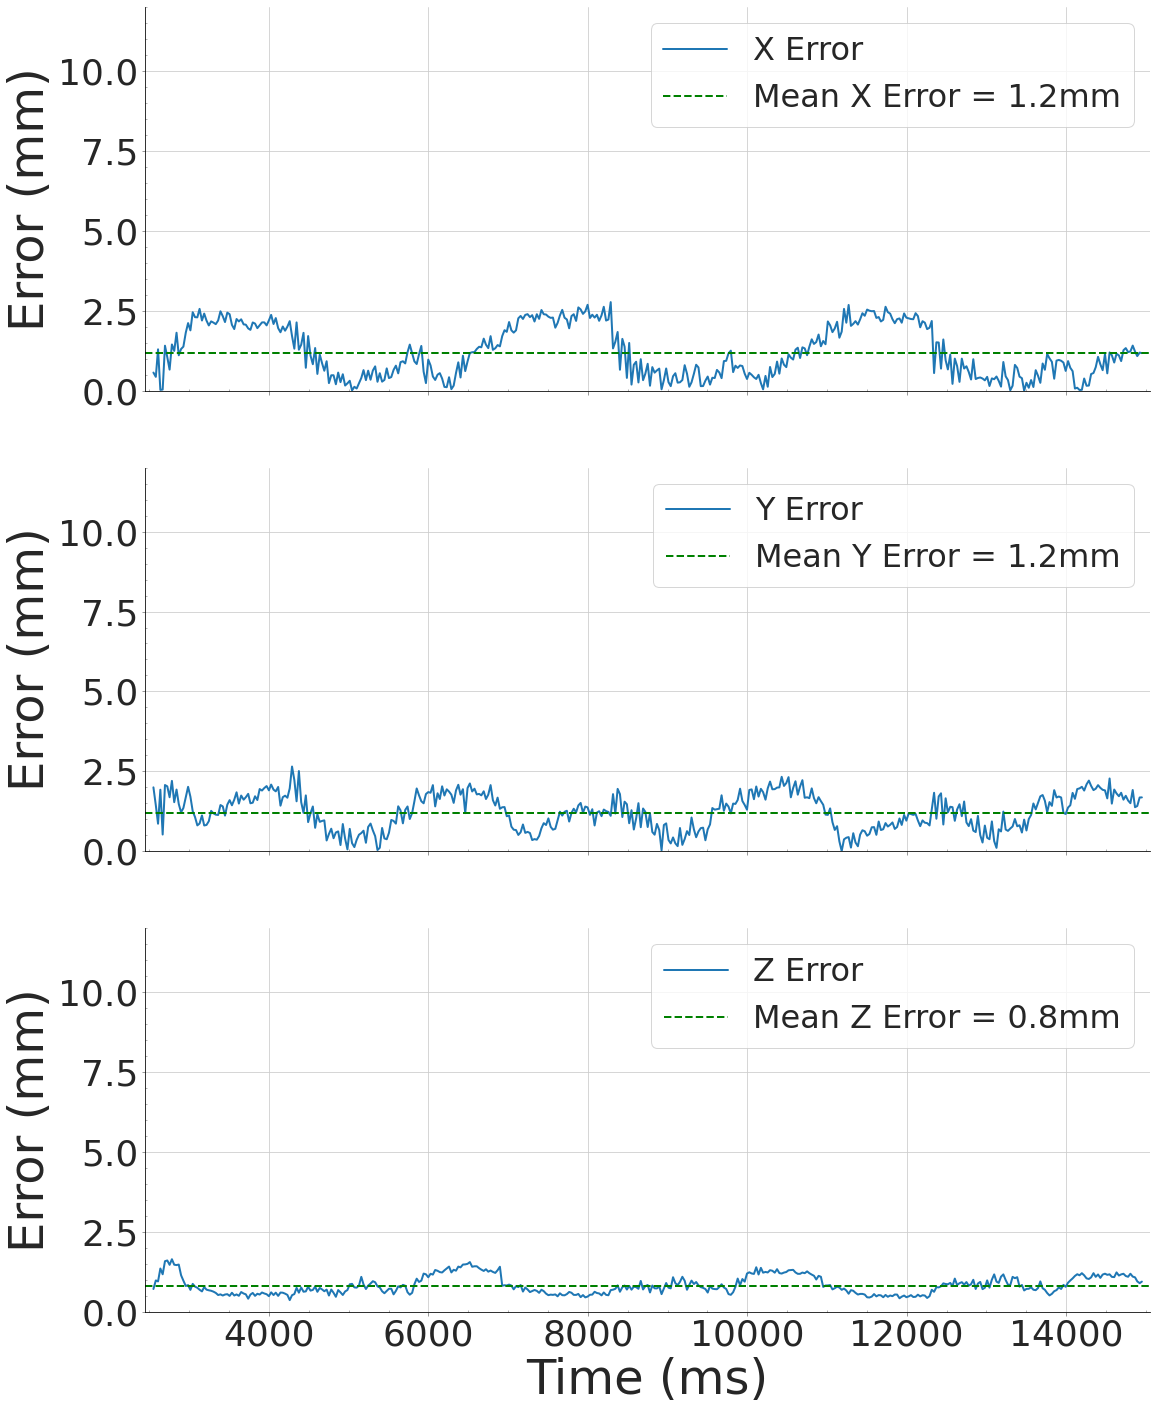

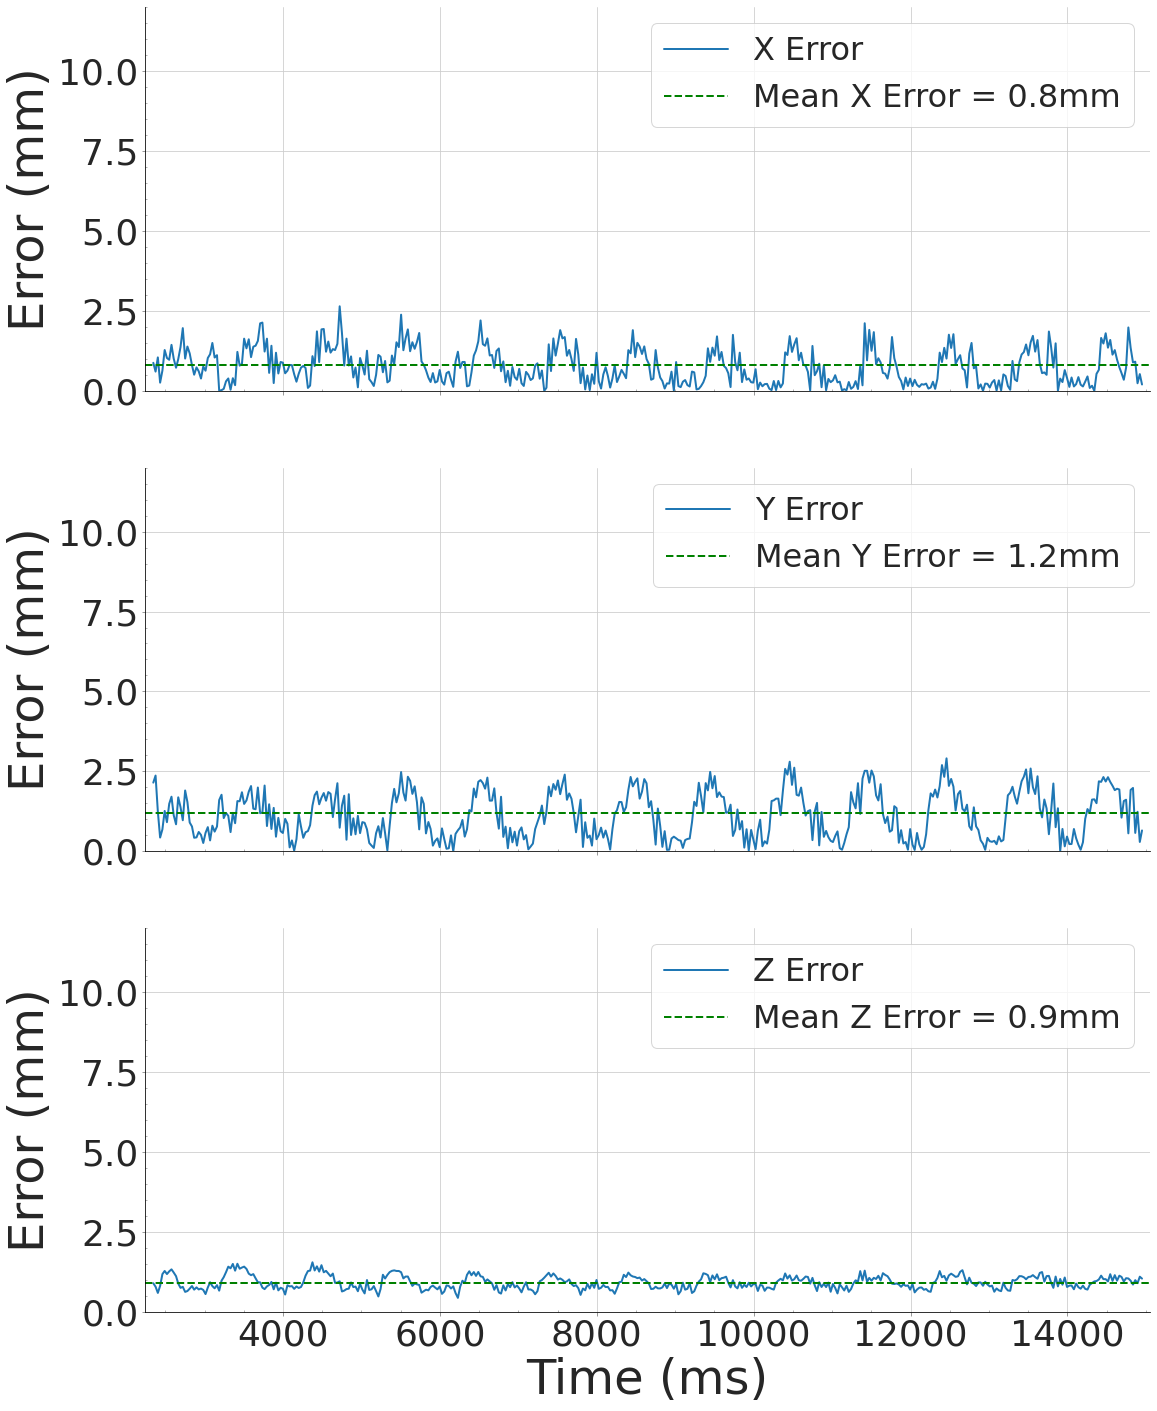

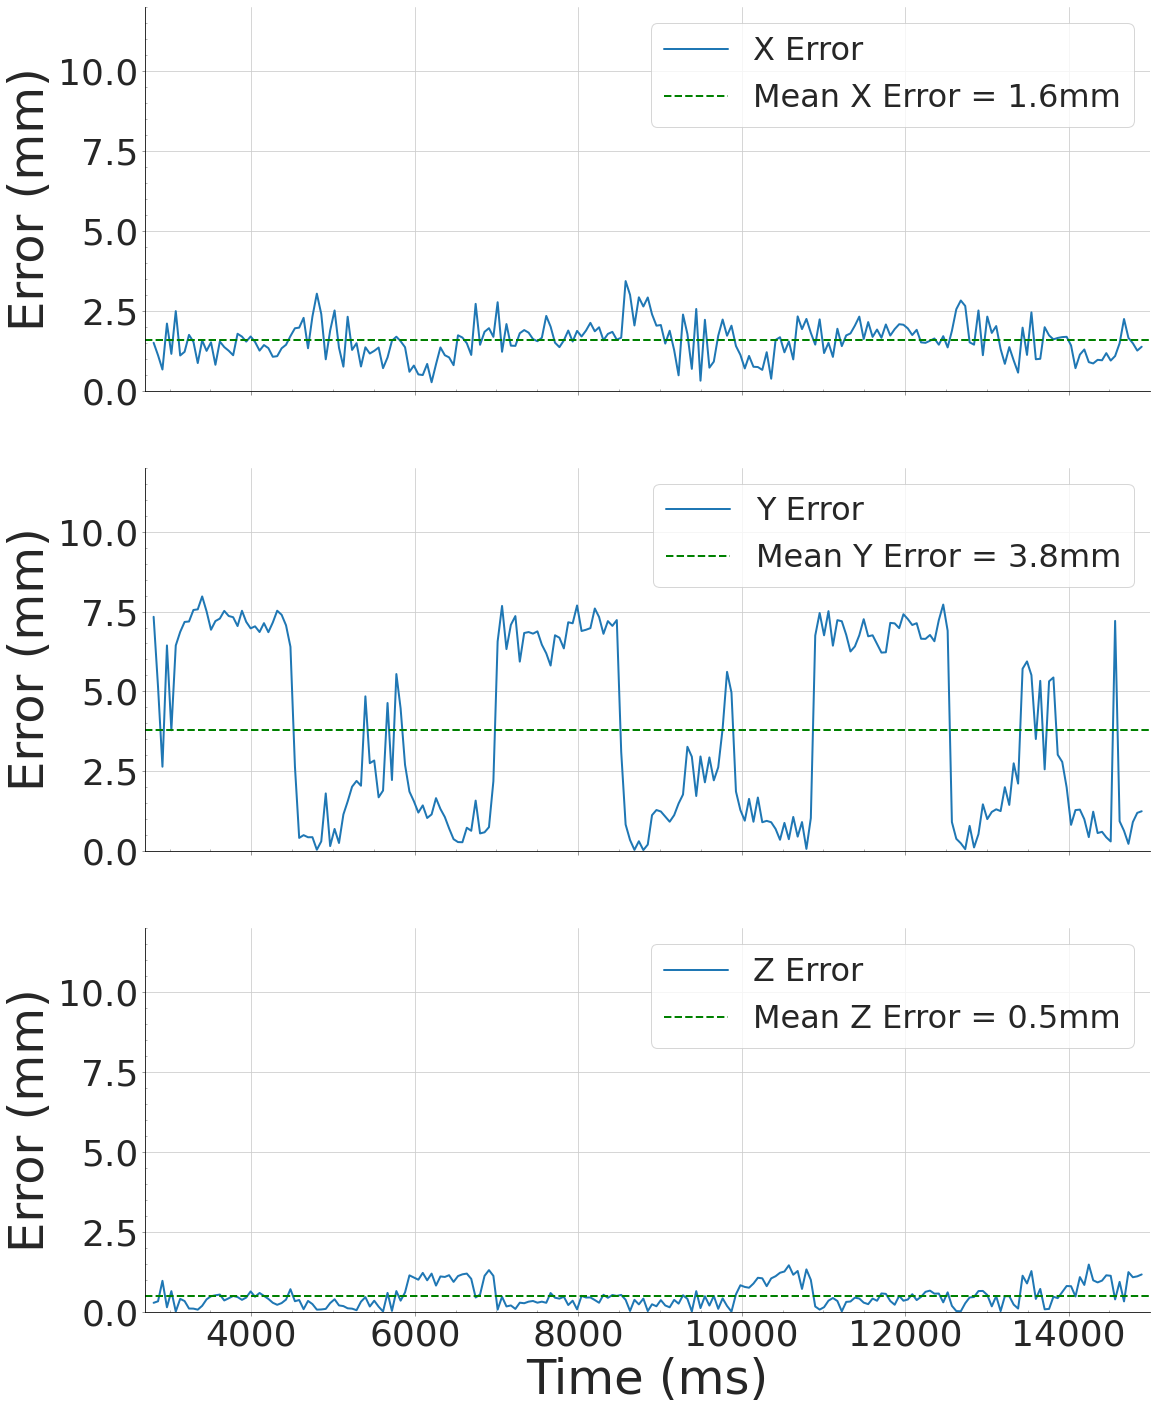

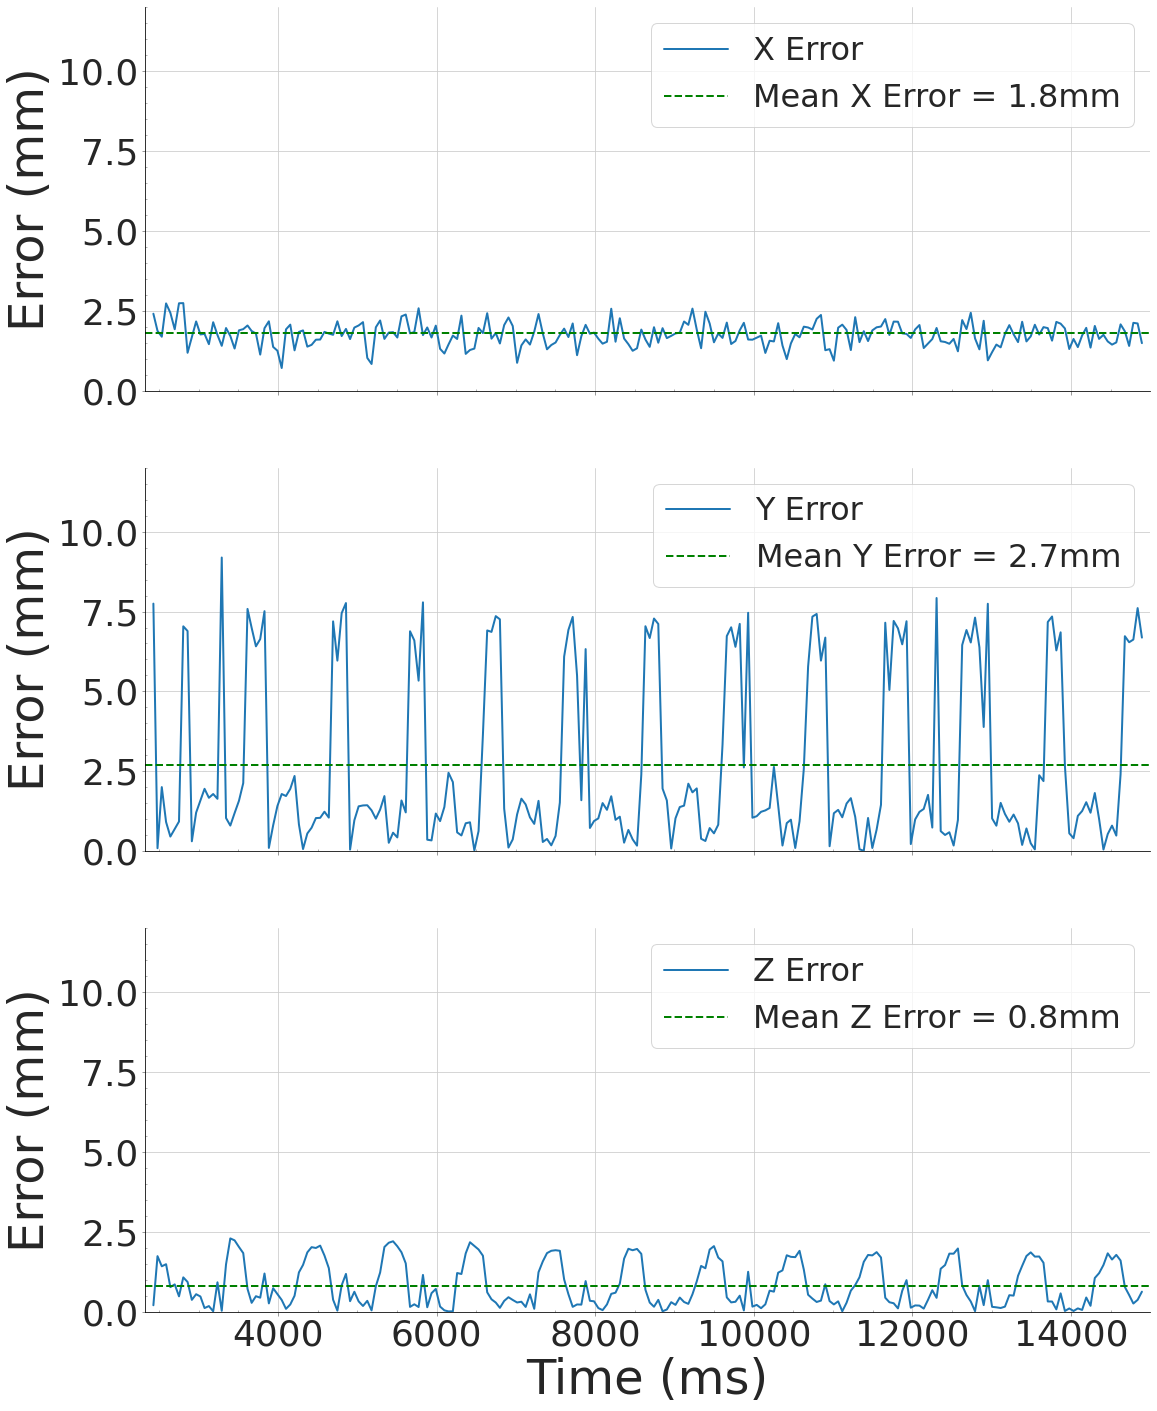

In [21]:
# # Plot error lineplots and save them to directory

# Sequence 1: Hadamard Multiplexed - JPNG
# plot_motion_error(FH512_2_jpng_7_231_resp, FH512_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_6_231_resp, FH512_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_tip_231_resp, FH512_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_7_231_card, FH512_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_6_231_card, FH512_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_tip_231_card, FH512_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_motion_error(FH512_2_jpng_7_299_resp, FH512_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_6_299_resp, FH512_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
plot_motion_error(FH512_2_jpng_tip_299_resp, FH512_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_7_299_card, FH512_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_6_299_card, FH512_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
plot_motion_error(FH512_2_jpng_tip_299_card, FH512_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_motion_error(FH512_2_jpng_7_306_resp, FH512_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_6_306_resp, FH512_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_tip_306_resp, FH512_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_7_306_card, FH512_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_6_306_card, FH512_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_tip_306_card, FH512_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 1: Hadamard Multiplexed - CAP
# plot_motion_error(FH512_2_cap_7_231_resp, FH512_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_6_231_resp, FH512_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_tip_231_resp, FH512_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_7_231_card, FH512_2_cap_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_6_231_card, FH512_2_cap_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_tip_231_card, FH512_2_cap_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_motion_error(FH512_2_cap_7_299_resp, FH512_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_6_299_resp, FH512_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_tip_299_resp, FH512_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_7_299_card, FH512_2_cap_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_6_299_card, FH512_2_cap_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_tip_299_card, FH512_2_cap_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_motion_error(FH512_2_cap_7_306_resp, FH512_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_6_306_resp, FH512_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_tip_306_resp, FH512_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_7_306_card, FH512_2_cap_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_6_306_card, FH512_2_cap_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_tip_306_card, FH512_2_cap_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# Sequence 2: Conventional - JPNG
# plot_motion_error(SRI_2_jpng_7_231_resp, SRI_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_6_231_resp, SRI_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_tip_231_resp, SRI_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_7_231_card, SRI_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_6_231_card, SRI_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_tip_231_card, SRI_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_motion_error(SRI_2_jpng_7_299_resp, SRI_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_6_299_resp, SRI_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
plot_motion_error(SRI_2_jpng_tip_299_resp, SRI_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_7_299_card, SRI_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_6_299_card, SRI_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
plot_motion_error(SRI_2_jpng_tip_299_card, SRI_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_motion_error(SRI_2_jpng_7_306_resp, SRI_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_6_306_resp, SRI_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_tip_306_resp, SRI_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_7_306_card, SRI_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_6_306_card, SRI_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_tip_306_card, SRI_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

# # Sequence 2: Conventional - CAP
# plot_motion_error(SRI_2_cap_7_231_resp, SRI_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_6_231_resp, SRI_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_tip_231_resp, SRI_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_7_231_card, SRI_2_cap_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_6_231_card, SRI_2_cap_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_tip_231_card, SRI_2_cap_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_motion_error(SRI_2_cap_7_299_resp, SRI_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_6_299_resp, SRI_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_tip_299_resp, SRI_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_7_299_card, SRI_2_cap_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_6_299_card, SRI_2_cap_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_tip_299_card, SRI_2_cap_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_motion_error(SRI_2_cap_7_306_resp, SRI_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_6_306_resp, SRI_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_tip_306_resp, SRI_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_7_306_card, SRI_2_cap_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_6_306_card, SRI_2_cap_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_tip_306_card, SRI_2_cap_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

Generate Error Boxplots

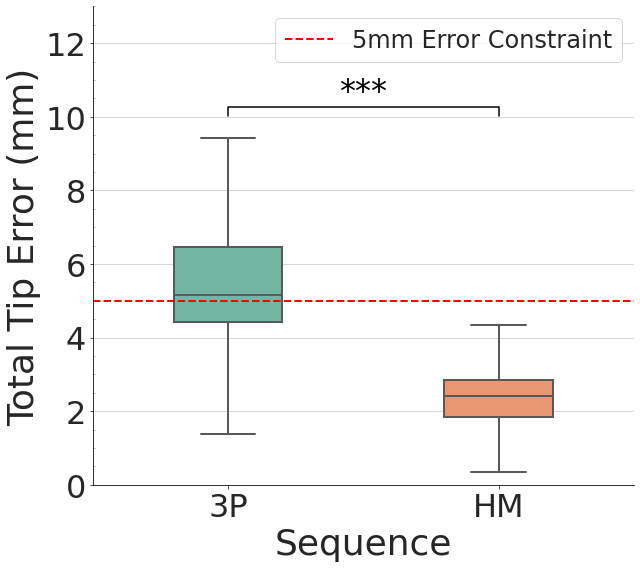

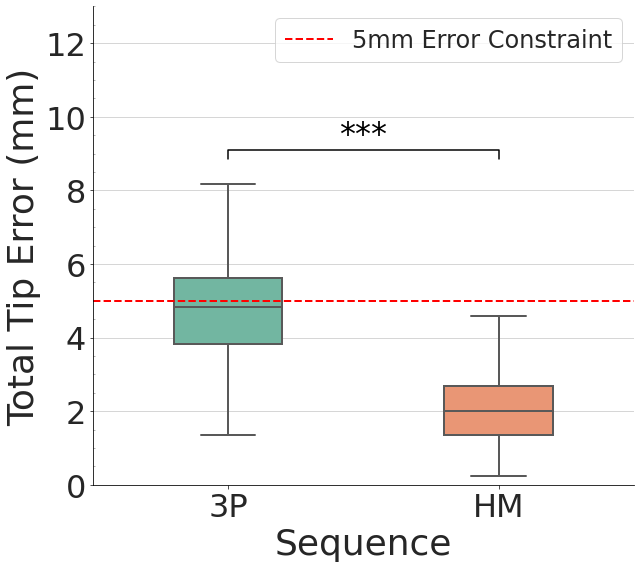

In [22]:
# Merge data for error boxplots, plot them, and save them to directory

plot_df_resp = merge_plot_dfs([SRI_2_jpng_plot_df_231_resp, SRI_2_jpng_plot_df_299_resp, SRI_2_jpng_plot_df_306_resp, FH512_2_jpng_plot_df_231_resp, FH512_2_jpng_plot_df_299_resp, FH512_2_jpng_plot_df_306_resp])
plot_df_card = merge_plot_dfs([SRI_2_jpng_plot_df_231_card, SRI_2_jpng_plot_df_299_card, SRI_2_jpng_plot_df_306_card, FH512_2_jpng_plot_df_231_card, FH512_2_jpng_plot_df_299_card, FH512_2_jpng_plot_df_306_card])

plot_error_box_plot(plot_df_resp, box_plot_path, sequences)
plot_error_box_plot(plot_df_card, box_plot_path, sequences)